#### Result for single episode run to find optimal State-Values (implementing known optimal policy)

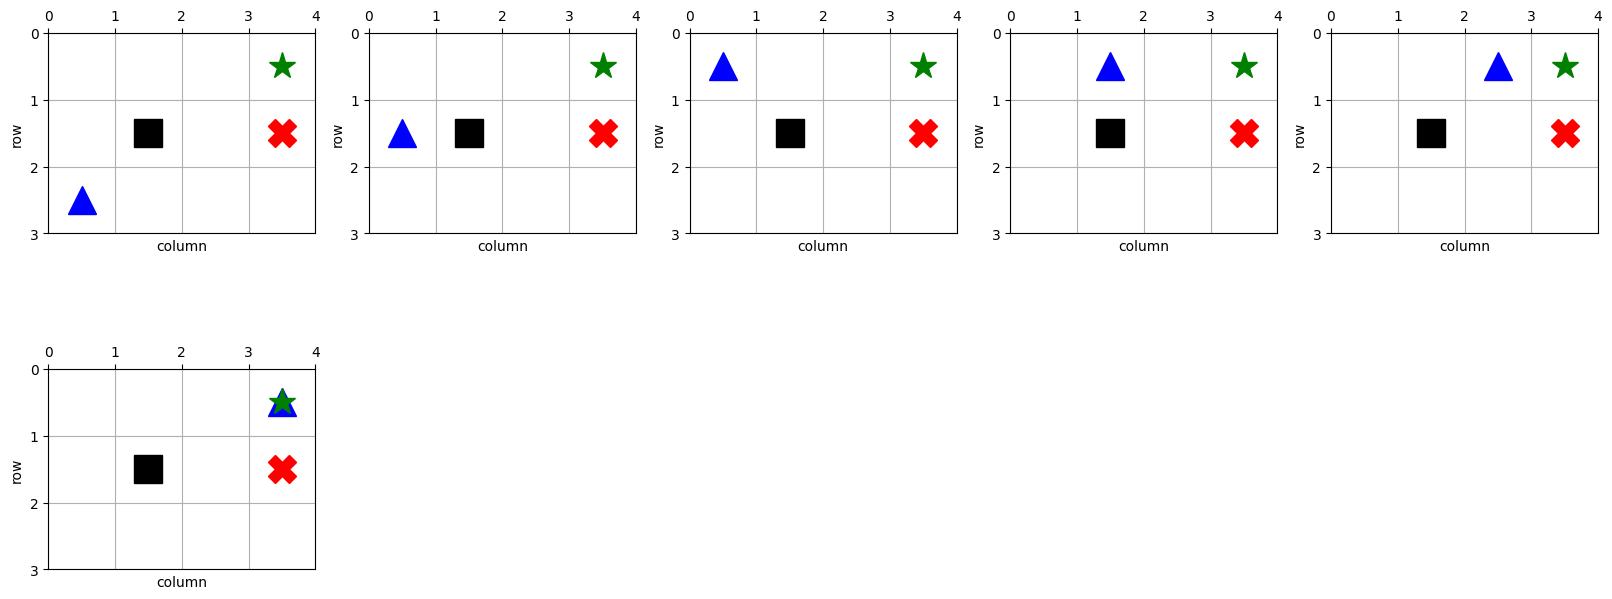

In [2]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import Gridworld

env = Gridworld()
robot_current_state = env.reset()

# Optimal policy using value iteration, {up=0, left=1, down=2, right=3}
policy = np.array([[3,      3, 3, -1],
                   [0, np.NaN, 0, -1],
                   [0,      1, 1,  1]])

iteration = 0
save_position = [robot_current_state]

# Now we can run an episode using a loop
for step_time in range(100): 
    action = policy[robot_current_state[0],robot_current_state[1]] # Next optimal action from robot_state

    next_position = env.step(action)
    
    state_reward = env.reward[next_position[0],next_position[1]] # reward at current state

    robot_current_state = next_position

    iteration += 1
    save_position.append(next_position)

    if env.state_matrix[next_position[0],next_position[1]] == 1:
        save_position.append(next_position)
        break

# Now plot the data
plt.figure(figsize=(20,8))
plt.tight_layout(pad=3.0) # give some spacing btw two subplots
for i in range(1, iteration+2):
    ax = plt.subplot(math.ceil((iteration+1)/5), 5, i) # math.ceil() will round the value to upper limit
    plt.plot(save_position[i-1][1] + 0.5, save_position[i-1][0] + 0.5, 'b^', markersize=20)
    plt.plot(np.where(env.reward == 1)[1] + 0.5, np.where(env.reward == 1)[0] + 0.5, 'g*', markersize=20) # Plot terminal state
    plt.plot(np.where(env.reward == -1)[1] + 0.5, np.where(env.reward == -1)[0] + 0.5, 'rX', markersize=20) # Plot stair state
    plt.plot(np.where(env.state_matrix == -1)[1] + 0.5, np.where(env.state_matrix == -1)[0] + 0.5, 'ks', markersize=20) # Plot obstacle state
    plt.ylim(0,env.world_row)
    plt.xlim(0,env.world_column)
    plt.grid()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_aspect('equal')
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False) # shift axis from bottom to top
    plt.gca().invert_yaxis() # invert row (3 to 0) because matrix indexing starts from top-left elements
    plt.ylabel('row')
    plt.xlabel('column')
plt.show()

#### Monte-Carlo Prediction (First Visit)

State-Value matrix after 7000 iterations:
[[ 0.77277061  0.84030981  0.90110669  1.        ]
 [ 0.71279218  0.          0.59271412 -1.        ]
 [ 0.64713443  0.59134475  0.          0.        ]]


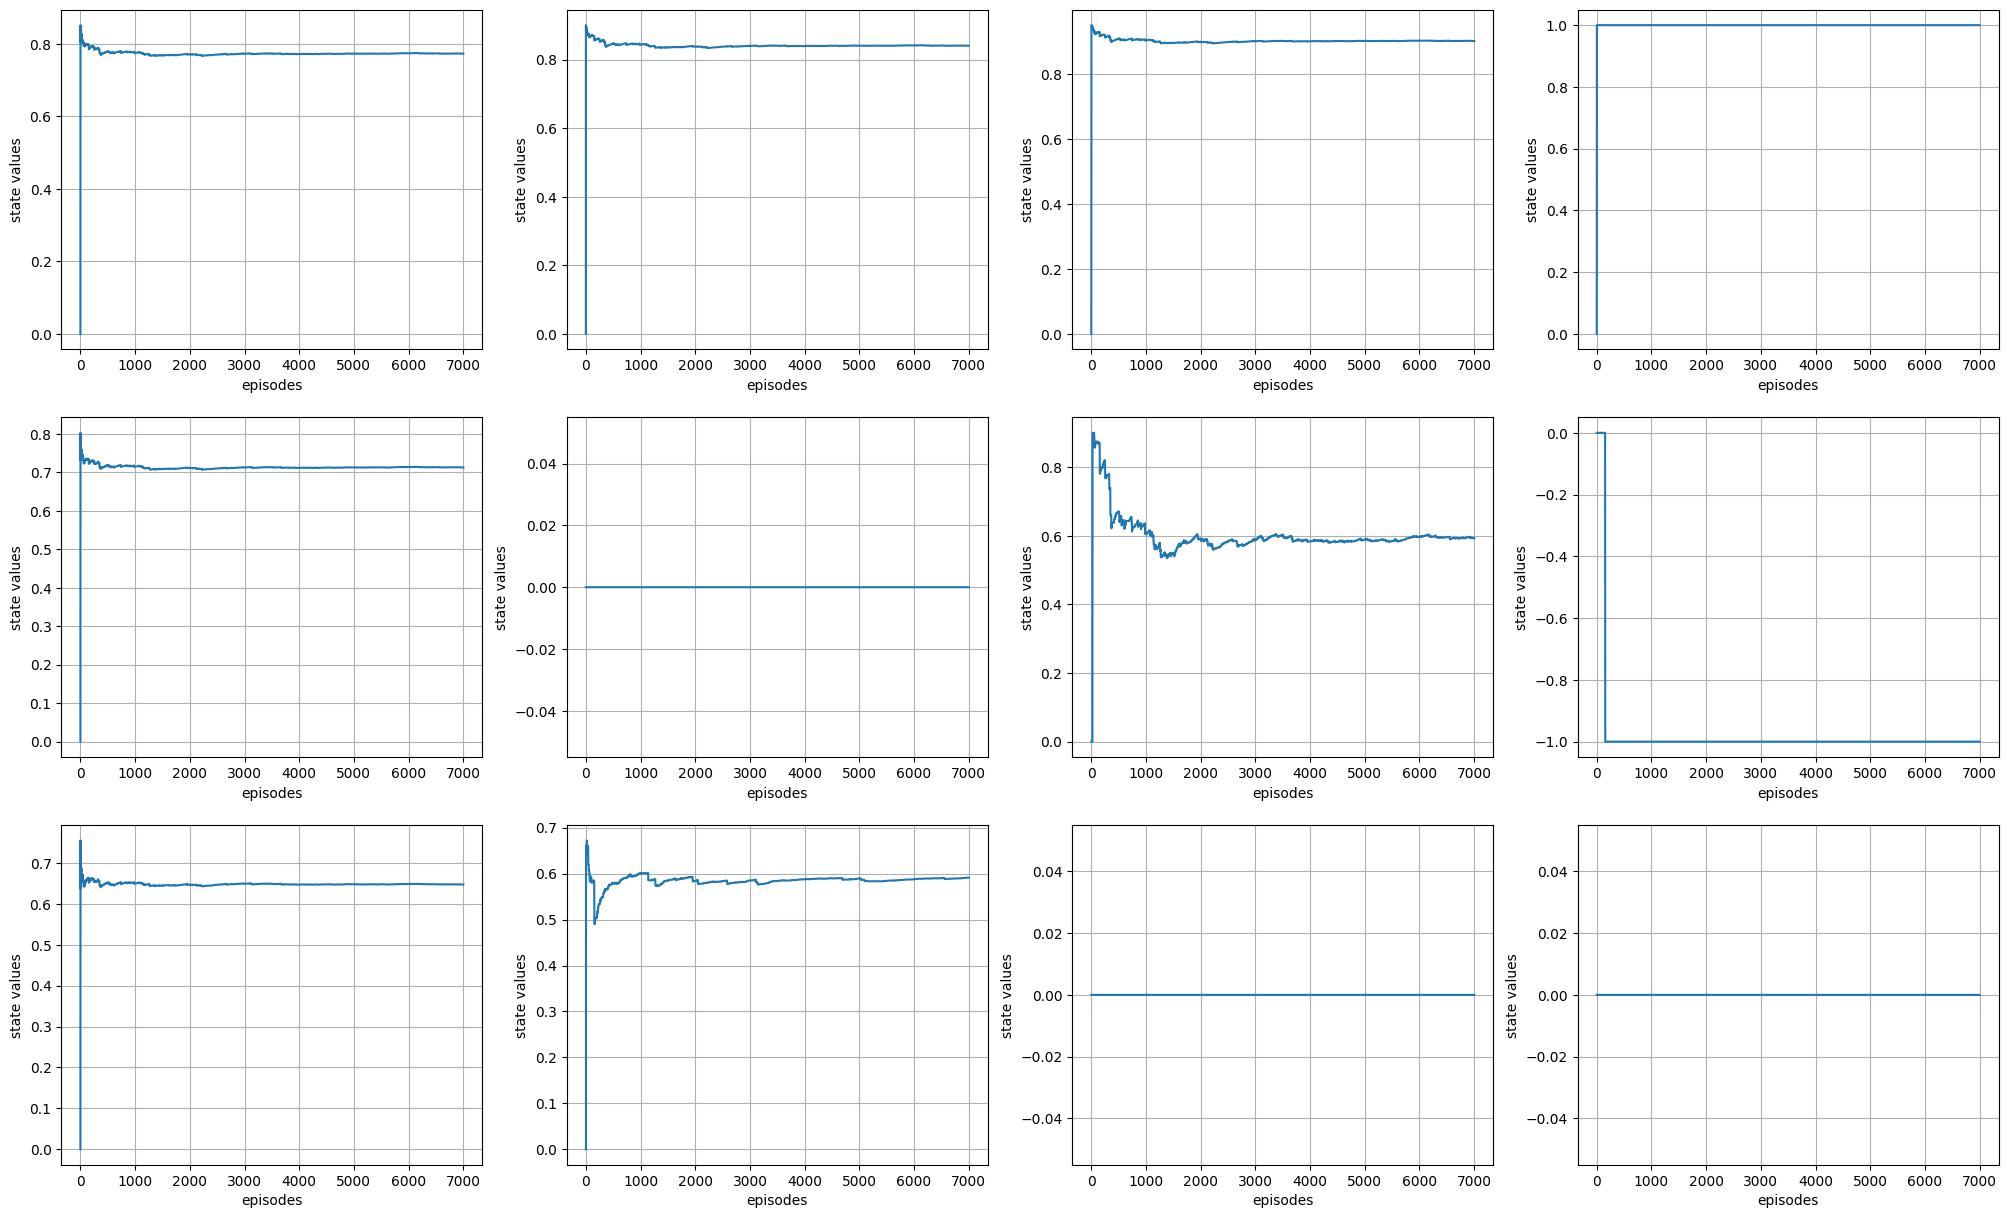

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import Gridworld

env = Gridworld()
gamma = 0.99 # discount factor

V = np.zeros((3,4)) # Defining an empty state-value matrix
N = np.zeros((3,4))  # Count of visits to each state
V_plot = np.zeros((12,1)) # store data for plotting

# INPUT -> Optimal policy using value iteration, {up=0, left=1, down=2, right=3}
policy = np.array([[3,      3, 3, -1],
                   [0, np.NaN, 0, -1],
                   [0,      1, 1,  1]])

tot_episodes = 7000 # no of eposides
time_step_for_task = 20 # time steps required to perform a task in one episode
for current_episode in range(tot_episodes):
    robot_current_state = env.reset() # Reset and return the first observation 
    episode_list = list() # Starting a new episode
    episode_list.append((robot_current_state, env.reward[robot_current_state[0], robot_current_state[1]]))

    # Now we can run for some time step within the episode
    for step_time in range(time_step_for_task): 
        action = policy[robot_current_state[0],robot_current_state[1]] # Next optimal action from robot_state

        next_position = env.step(action) # perform this action

        state_reward = env.reward[next_position[0],next_position[1]] # reward at current state

        robot_current_state = next_position  # Update robot current position (observation at t+1)

        # In episode list we need to store the observation at t+1 and the reward obtained at t+1
        episode_list.append((robot_current_state,state_reward)) # Append the visit in the episode list -> {S1[x0,r1], S2[x1,r2], S3[x2,r3], S4[x3,r4], .... ,Sn[x19,r20]}, n=20 is length of each episode

        if env.state_matrix[next_position[0],next_position[1]] == 1: # Terminal State
            break

    G = 0
    # implementation of First-Visit MC (there are total 12 states [X1,X2,X3,..,X12], and n(>12) samples, so, x0,x1,x2-----x(n-1) has repatative states)
    for t in range(len(episode_list) - 1, -1, -1):  # t <- [n-1, 18, 17, 16, 15, 14, ---------- 5, 4, 3, 2, 1, 0]
        state, reward = episode_list[t] # state = [x,y], reward = r
        G = gamma * G + reward  # Discounted return

        if state not in [e[0] for e in episode_list[:t]]:
            N[state[0], state[1]] += 1
            V[state[0], state[1]] += (G - V[state[0], state[1]]) / N[state[0], state[1]]
        
    V_plot = np.hstack((V_plot, V.reshape(12,1))) # save state values for graph plotting

# Time to check the utility matrix obtained
print("State-Value matrix after " + str(tot_episodes) + " iterations:")
print(V)  

# Convergences Plot of state-values
plt.figure(figsize=(25,15))
for i in range(1, (env.world_row*env.world_column)+1):
    plt.subplot(env.world_row, env.world_column, i) # math.ceil() will round the value to upper limit
    plt.plot(np.arange(tot_episodes+1),V_plot[i-1,:])
    plt.grid()
    plt.ylabel('state values')
    plt.xlabel('episodes')
plt.show()